# Clasificador paisajes
Para este ejercicio vas a crear un clasificador automático de paisajes. Los datos los encontrarás en el Clasroom como `seg_train.zip` y `seg_test.zip`. Se pide:
1. Cargar las imágenes. Mira cómo están almacenados los datos. Tendrás que recorrer las carpetas, cargar las imágenes en memoria y etiquetarlas con los nombres de las carpetas. Realiza un reshape de cada imagen (comienza el ejercicio con 32x32, para ir más rápido en las ejecuciones).
2. Investiga las imágenes, comprueba con algunas muestras que has cargado bien los datos.
3. Normaliza
4. Diseña la arquitectura de la red. Recuerda que es un algiritmo de clasificación. Ojo con las dimensiones de la entrada
5. Reserva un 20% de los datos del entrenamiento para validar.
6. Representa el objeto history
7. Evalua el modelo con los datos de test
8. Representa algunos de los paisajes donde el modelo comete errores
9. Crea una matriz de confusión con los errores del modelo

**NOTA apartado 1**: para el apartado 1 tendras que recorre las carpetas/imagenes con `os.listdir()`, e ir cargando todas las imagenes como arrays de numpy

**NOTA apartado 4**: empieza con un par de capas Conv2D + MaxPooling2D con activación relu y después la fully connected layer. on softmax como ultima capa

In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (32, 32)

In [17]:
print(class_names)
print(class_names_label)
print(type(list(class_names_label.keys())[0]))

['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
{'mountain': 0, 'street': 1, 'glacier': 2, 'buildings': 3, 'sea': 4, 'forest': 5}
<class 'str'>


In [65]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf   

## Loading images

In [22]:
os.listdir('C:/Users/Daney/Desktop/intel_classif/seg_train/seg_train')

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [23]:
# Para eliminar el mac
# from os import remove
#remove("/Users/usuario_name/Desktop/paisajes/mini_train/.DS_Store")
# if file[-3:]!= "ore":

def load_data():
    
    datasets = ['C:/Users/Daney/Desktop/intel_classif/seg_train/seg_train',
               'C:/Users/Daney/Desktop/intel_classif/seg_test/seg_test']
    
    output = []
    
    for dataset in datasets:
        print("Loading:", dataset)
        
        images = []
        labels = []
        
        for folder in os.listdir(dataset):
            print("Folder:", folder)
            label = class_names_label[folder]
            #print(label)
            
            #if folder != '.DS_Store':
            
            for file in os.listdir(dataset + '/' + folder):
                #print(file)
                
                img_path = dataset + '/' + folder + '/' + file
                # img_path = os.path.join(os.path.join(dataset, folder), file)
                
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)
                
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')
        
        output.append((images, labels))
        
    return output         


In [24]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading: C:/Users/Daney/Desktop/intel_classif/seg_train/seg_train
Folder: buildings
Folder: forest
Folder: glacier
Folder: mountain
Folder: sea
Folder: street
Loading: C:/Users/Daney/Desktop/intel_classif/seg_test/seg_test
Folder: buildings
Folder: forest
Folder: glacier
Folder: mountain
Folder: sea
Folder: street


In [25]:
# Mezclamos datos
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)

## Investigar imagenes

In [28]:
n_train = train_labels.shape[0]
n_test= test_labels.shape[0]

print("Imagenes train:", n_train)
print("Imagenes test:", n_test)

Imagenes train: 14034
Imagenes test: 3000


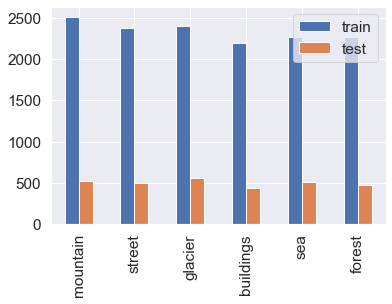

In [31]:
# Imagenes de cada clase, por train/test
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)

pd.DataFrame({'train': train_counts,
             'test': test_counts},
            index=class_names).plot.bar();

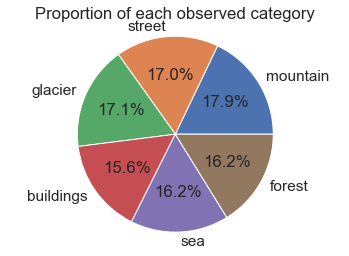

In [32]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')

plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

## Escalamos

In [33]:
train_images = train_images / 255.0
test_images = test_images / 255.0

## Visualizamos

In [34]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

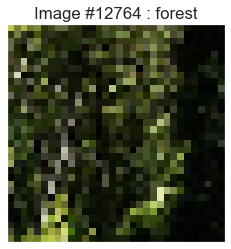

In [38]:
display_random_image(class_names, train_images, train_labels)

In [39]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

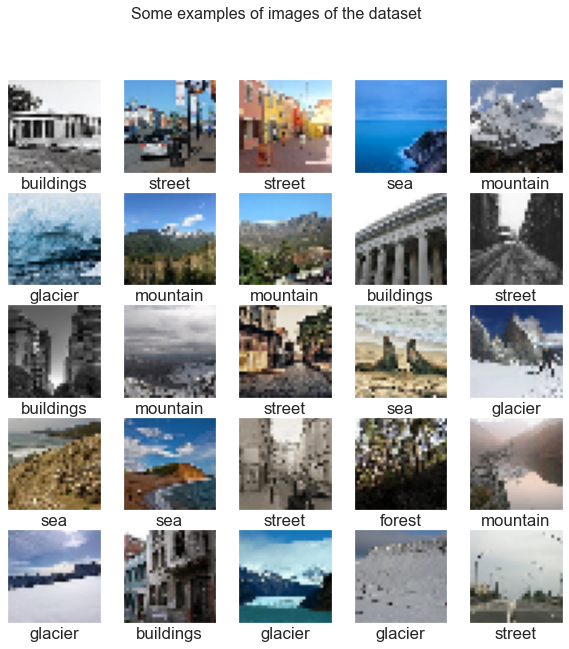

In [40]:
display_examples(class_names, train_images, train_labels)

## Model

In [41]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',
                          input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [42]:
model.compile(optimizer='adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [43]:
history = model.fit(train_images,
                   train_labels,
                   epochs=10,
                   validation_split=0.2)

Epoch 1/10
351/351 [==============================] - 14s 41ms/step - loss: 1.0929 - accuracy: 0.5729 - val_loss: 0.8662 - val_accuracy: 0.6701
Epoch 2/10
351/351 [==============================] - 15s 41ms/step - loss: 0.8470 - accuracy: 0.6903 - val_loss: 0.7820 - val_accuracy: 0.7157
Epoch 3/10
351/351 [==============================] - 15s 42ms/step - loss: 0.7402 - accuracy: 0.7282 - val_loss: 0.7004 - val_accuracy: 0.7467
Epoch 4/10
351/351 [==============================] - 14s 41ms/step - loss: 0.6665 - accuracy: 0.7574 - val_loss: 0.7117 - val_accuracy: 0.7421
Epoch 5/10
351/351 [==============================] - 14s 41ms/step - loss: 0.6163 - accuracy: 0.7768 - val_loss: 0.7057 - val_accuracy: 0.7424
Epoch 6/10
351/351 [==============================] - 14s 41ms/step - loss: 0.5703 - accuracy: 0.7930 - val_loss: 0.7129 - val_accuracy: 0.7396
Epoch 7/10
351/351 [==============================] - 14s 40ms/step - loss: 0.5261 - accuracy: 0.8113 - val_loss: 0.6768 - val_accuracy:

In [44]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(15,10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

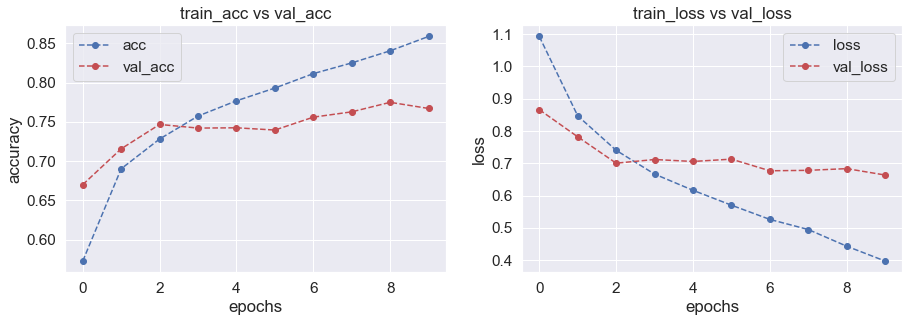

In [49]:
plot_accuracy_loss(model.history)

In [48]:
model.history

{'loss': [1.0929490327835083,
  0.8469601273536682,
  0.7402027249336243,
  0.6665359139442444,
  0.6163474917411804,
  0.570255696773529,
  0.5261437892913818,
  0.4948379397392273,
  0.44316479563713074,
  0.39714184403419495],
 'accuracy': [0.5729045867919922,
  0.6903001666069031,
  0.7281553149223328,
  0.75737065076828,
  0.7767881155014038,
  0.7929990291595459,
  0.8113476634025574,
  0.8249754905700684,
  0.8403847813606262,
  0.8586443662643433],
 'val_loss': [0.8661987781524658,
  0.7820368409156799,
  0.700384259223938,
  0.7117118239402771,
  0.7057104706764221,
  0.7128623723983765,
  0.6768044829368591,
  0.6781815886497498,
  0.6834696531295776,
  0.6636110544204712],
 'val_accuracy': [0.6701104640960693,
  0.7157106995582581,
  0.746704638004303,
  0.7420734167098999,
  0.7424296140670776,
  0.7395796179771423,
  0.7559671998023987,
  0.7627360224723816,
  0.7748485803604126,
  0.7670110464096069]}

In [50]:
test_loss = model.evaluate(test_images, test_labels)

94/94 [==============================] - 1s 8ms/step - loss: 0.6744 - accuracy: 0.7667


In [51]:
test_loss

[0.6743968725204468, 0.7666666507720947]

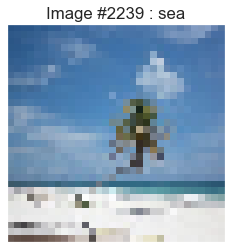

In [59]:
predictions = model.predict(test_images)

preds_labels = np.argmax(predictions, axis=1)

display_random_image(class_names, test_images, preds_labels)

In [61]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    
    mask = test_labels == pred_labels
    mislabeled_index = np.where(mask == False)
    mislabeled_images = test_images[mislabeled_index]
    mislabeled_labels = preds_labels[mislabeled_index]
    
    display_examples(class_names, mislabeled_images, mislabeled_labels)

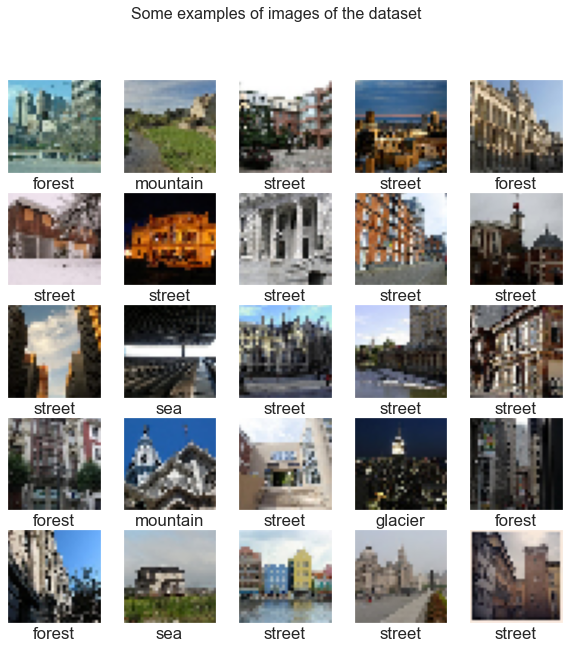

In [63]:
print_mislabeled_images(class_names, test_images, test_labels, preds_labels)

## Confusion matrix

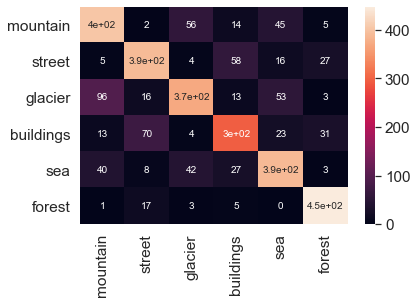

In [73]:
CM = confusion_matrix(test_labels, preds_labels)

sns.heatmap(CM,
           annot=True,
            annot_kws={"size":10},
           xticklabels=class_names,
           yticklabels=class_names);